In [1]:
# libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plot
import tensorflow as tf

from scipy.linalg import svd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.seasonal import MSTL
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, SimpleRNN

from sklearn.preprocessing import MinMaxScaler


In [2]:
# Read and preprocess the dataf
energy_data = pd.read_csv("NI_hourly.csv")
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])
energy_data['hour'] = energy_data['Datetime'].dt.hour
energy_data['date'] = energy_data['Datetime'].dt.date

# Sort chronologically by Datetime
energy_data = energy_data.sort_values('Datetime')
energy_data.set_index('Datetime',inplace=True)

In [3]:
# initial print check to see if everything is okay
print(energy_data)

                       NI_MW  hour        date
Datetime                                      
2004-05-01 01:00:00   9198.0     1  2004-05-01
2004-05-01 02:00:00   8570.0     2  2004-05-01
2004-05-01 03:00:00   8183.0     3  2004-05-01
2004-05-01 04:00:00   7917.0     4  2004-05-01
2004-05-01 05:00:00   7828.0     5  2004-05-01
...                      ...   ...         ...
2010-12-31 20:00:00  11585.0    20  2010-12-31
2010-12-31 21:00:00  11243.0    21  2010-12-31
2010-12-31 22:00:00  10825.0    22  2010-12-31
2010-12-31 23:00:00  10511.0    23  2010-12-31
2011-01-01 00:00:00  10042.0     0  2011-01-01

[58450 rows x 3 columns]


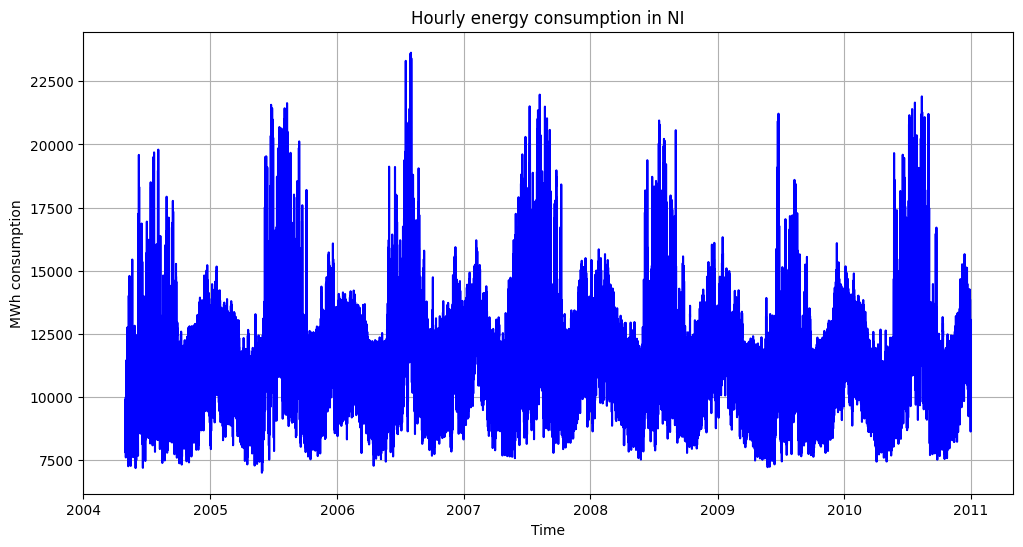

In [4]:

# Plot hourly consumption
plot.figure(figsize=(12, 6))
plot.plot(energy_data['NI_MW'], color='blue')
plot.xlabel('Time')
plot.ylabel('MWh consumption')
plot.title('Hourly energy consumption in NI')
plot.grid()
plot.show()

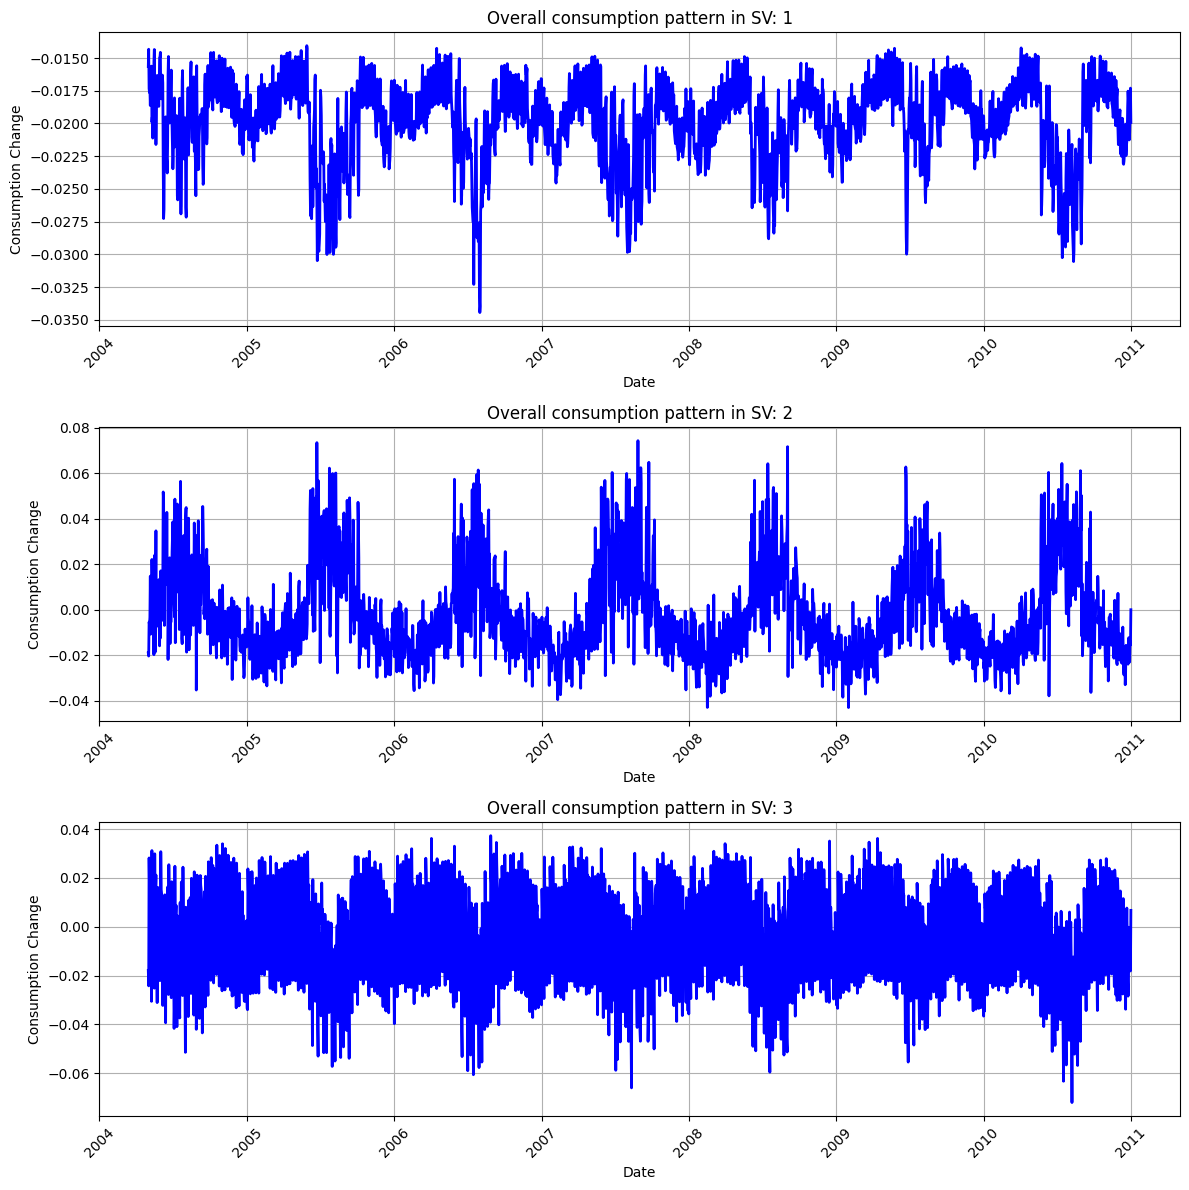

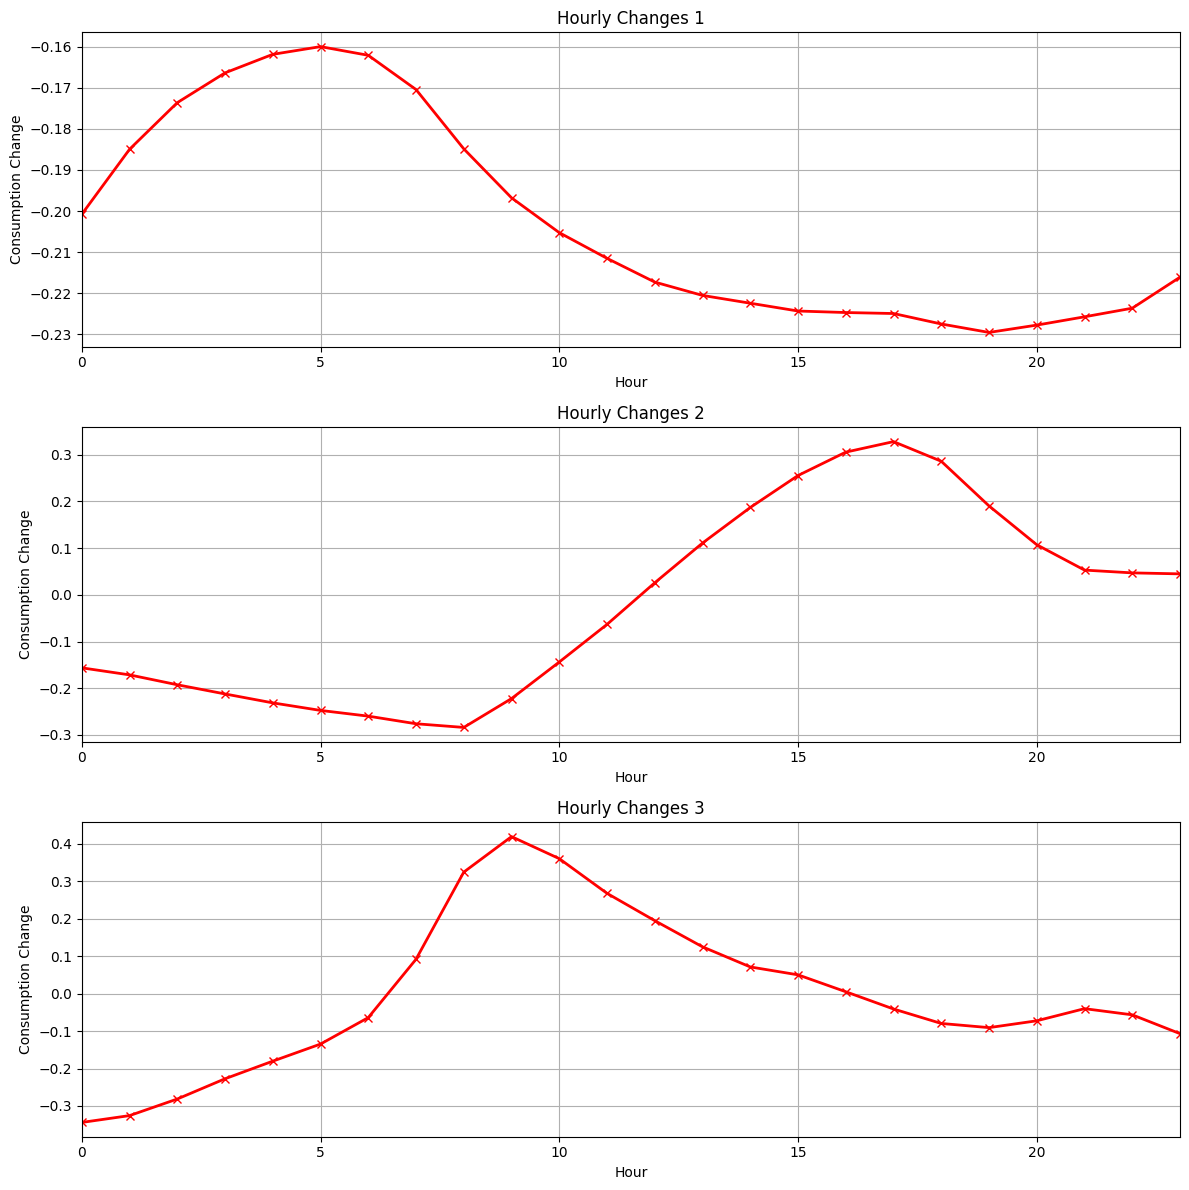

In [5]:
# Create pivot table for SVD analysis
pivoted_data = energy_data.pivot_table(
    values='NI_MW', 
    index='date',
    columns='hour',
    aggfunc='mean'
)
pivoted_data = pivoted_data.fillna(pivoted_data.mean())
matrix = pivoted_data.values

# Perform SVD
U, S, Vt = svd(matrix, full_matrices=False)
V = Vt.T

# Plot overall consumption patterns from SVD
plot.figure(figsize=(12, 12))
for i in range(3):
    plot.subplot(3, 1, i+1)
    plot.plot(pivoted_data.index, U[:, i], linewidth=2, color='blue')
    plot.title(f'Overall consumption pattern in SV: {i+1}')
    plot.xlabel('Date')
    plot.ylabel('Consumption Change')
    plot.grid(True)
    plot.xticks(rotation=45)
plot.tight_layout()
plot.show()

# Plot hourly patterns from SVD
plot.figure(figsize=(12, 12))
for i in range(3):
    plot.subplot(3, 1, i+1)
    plot.plot(range(24), V[:, i], 'rx-', linewidth=2)
    plot.title(f'Hourly Changes {i+1}')
    plot.xlabel('Hour')
    plot.ylabel('Consumption Change')
    plot.xlim(0, 23)
    plot.grid(True)
plot.tight_layout()
plot.show()

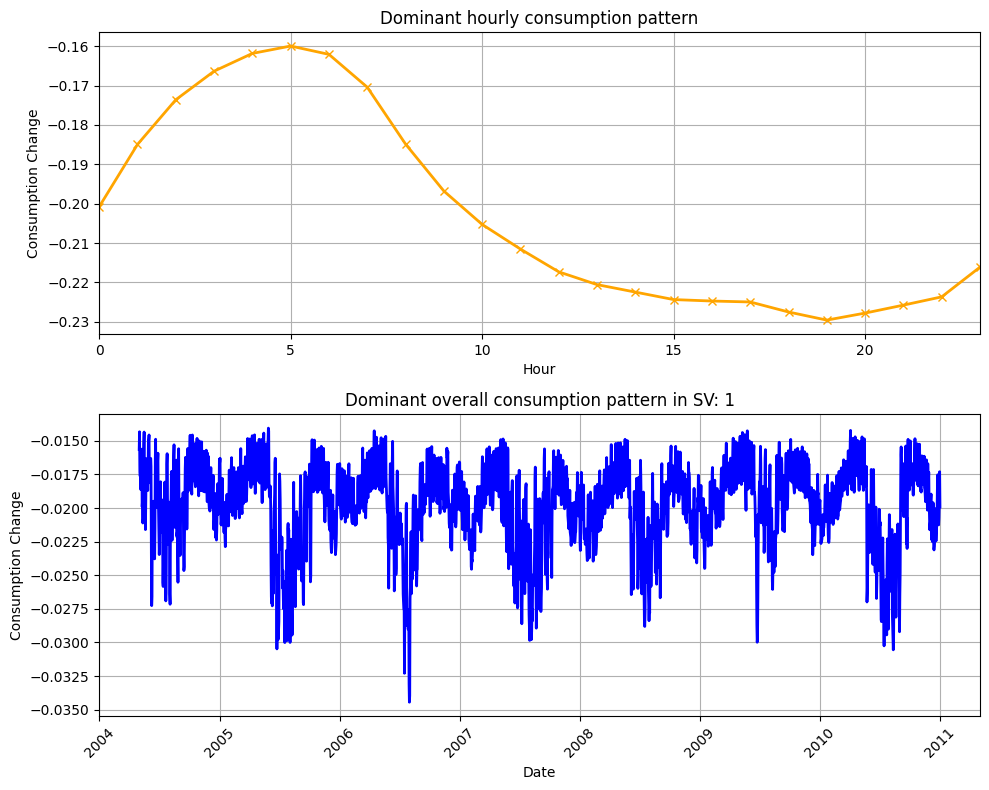

In [6]:
# Create figure with 2 subplots arranged vertically
fig, (ax1, ax2) = plot.subplots(2, 1, figsize=(10, 8))

# First subplot
hours = np.arange(24)  # 0:23
ax1.plot(hours, V[:,0], 'orange', marker='x', linewidth=2)
ax1.set_title('Dominant hourly consumption pattern')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Consumption Change')
ax1.set_xlim([0, 23])
ax1.grid(True)

# Second subplot
ax2.plot(pivoted_data.index, U[:, 0], linewidth=2, color='blue')  # Fixed this line
ax2.set_title(f'Dominant overall consumption pattern in SV: {1}')
ax2.set_xlabel('Date')
ax2.set_ylabel('Consumption Change')
plot.setp(ax2.xaxis.get_ticklabels(), rotation=45)
ax2.grid(True)

# Adjust layout to prevent overlap
plot.tight_layout()

# Display the plot
plot.show()

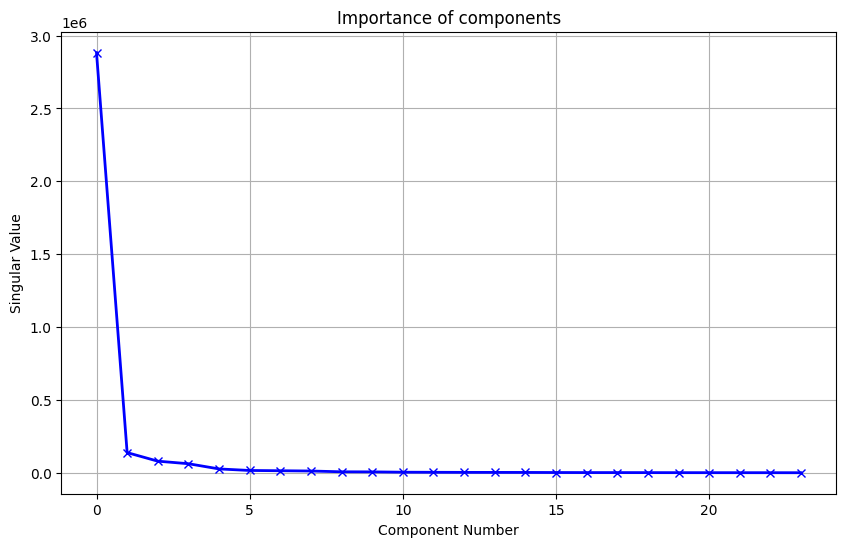

In [7]:
# Plot singular values

plot.figure(figsize=(10, 6))
plot.plot(S, 'bx-', linewidth=2)
plot.xlabel('Component Number')
plot.ylabel('Singular Value')
plot.title('Importance of components')
plot.grid(True)
plot.show()

In [8]:
# Index reset here - Just for Erics section with the decomp
energy_data = energy_data.reset_index()


In [9]:
print(energy_data['Datetime'])

0       2004-05-01 01:00:00
1       2004-05-01 02:00:00
2       2004-05-01 03:00:00
3       2004-05-01 04:00:00
4       2004-05-01 05:00:00
                ...        
58445   2010-12-31 20:00:00
58446   2010-12-31 21:00:00
58447   2010-12-31 22:00:00
58448   2010-12-31 23:00:00
58449   2011-01-01 00:00:00
Name: Datetime, Length: 58450, dtype: datetime64[ns]


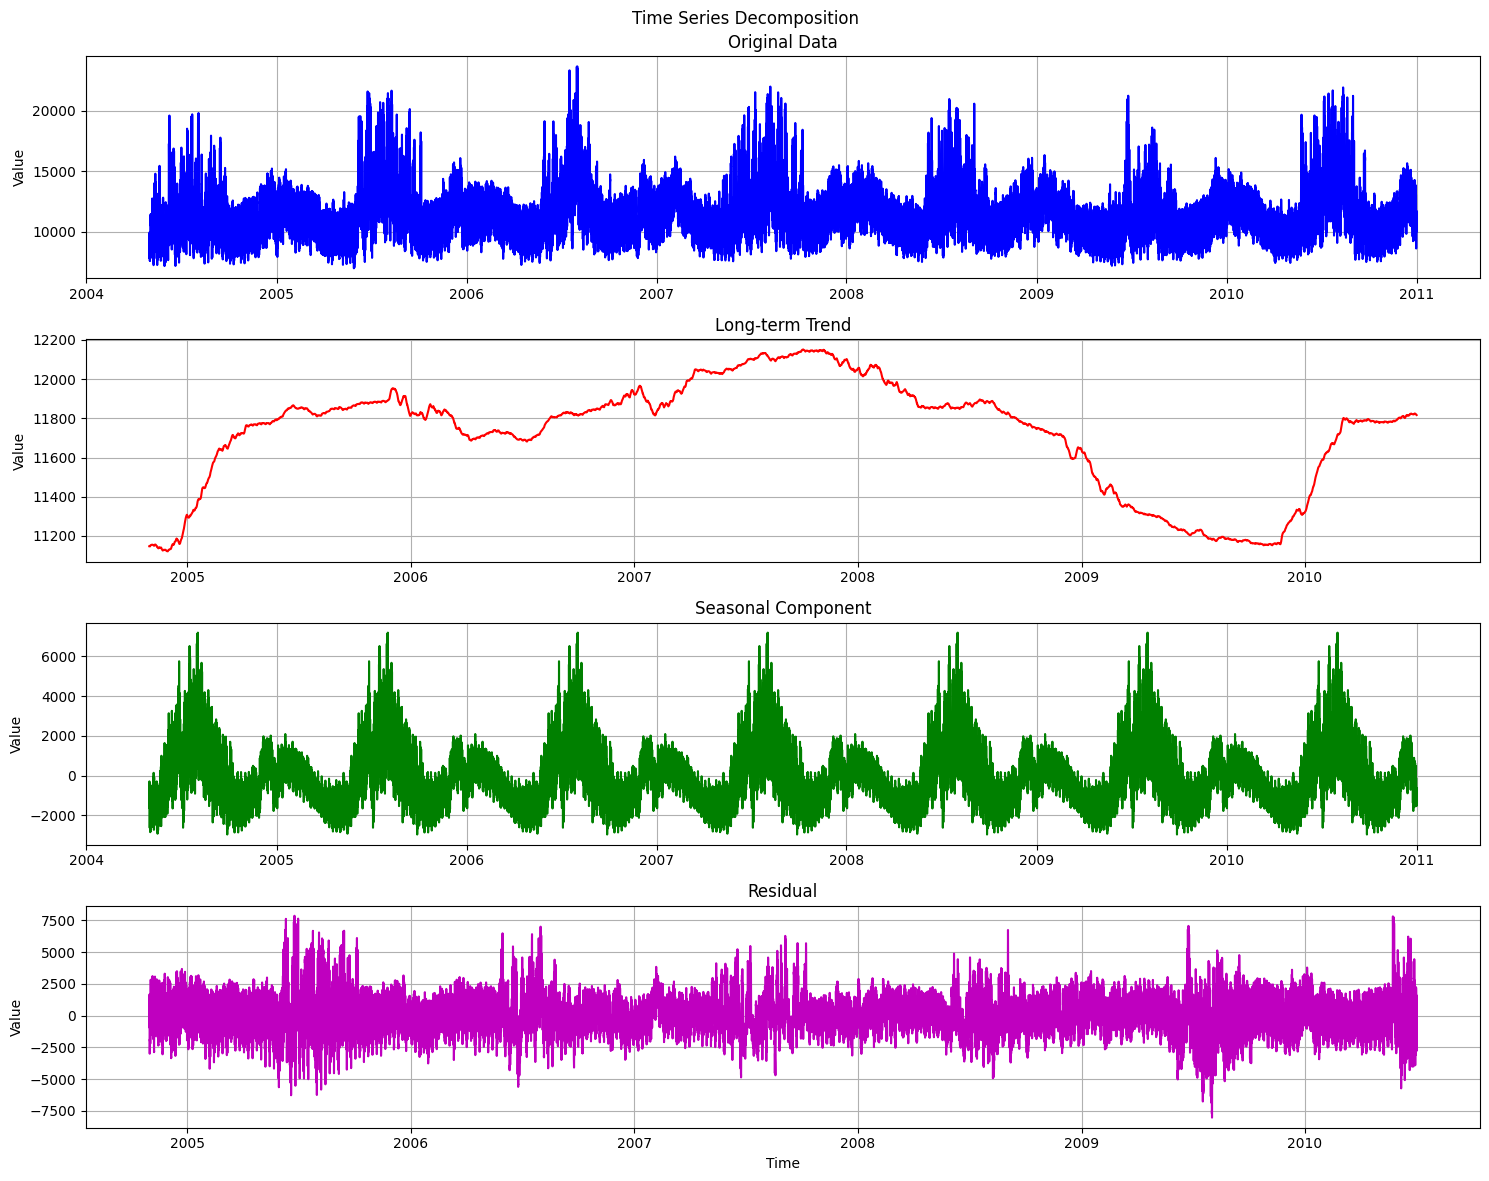

In [10]:
# Time series decomposition
ts_data = pd.Series(
    energy_data['NI_MW'].values,
    index=pd.DatetimeIndex(energy_data['Datetime']),
    name='NI_MW'
)
ts_data = ts_data.sort_index()

# Perform decomposition

# Yearly seasonality
decomposition = seasonal_decompose(
    ts_data,
    model="additive",
    period=24*365, # yearly seasonality
    extrapolate_trend=0
)


# Plot decomposition results
fig, (ax1, ax2, ax3, ax4) = plot.subplots(4, 1, figsize=(15, 12))

# Original Data
ax1.plot(ts_data.index, ts_data.values, 'b-', linewidth=1.5)
ax1.set_title('Original Data')
ax1.grid(True)
ax1.set_ylabel('Value')

# Trend
ax2.plot(ts_data.index, decomposition.trend, 'r-', linewidth=1.5)
ax2.set_title('Long-term Trend')
ax2.grid(True)
ax2.set_ylabel('Value')

# Seasonal
ax3.plot(ts_data.index, decomposition.seasonal, 'g-', linewidth=1.5)
ax3.set_title('Seasonal Component')
ax3.grid(True)
ax3.set_ylabel('Value')

# Residual
ax4.plot(ts_data.index, decomposition.resid, 'm-', linewidth=1.5)
ax4.set_title('Residual')
ax4.grid(True)
ax4.set_xlabel('Time')
ax4.set_ylabel('Value')


# Adjust layout for decomposition plot
plot.suptitle('Time Series Decomposition')
plot.tight_layout()
plot.show()

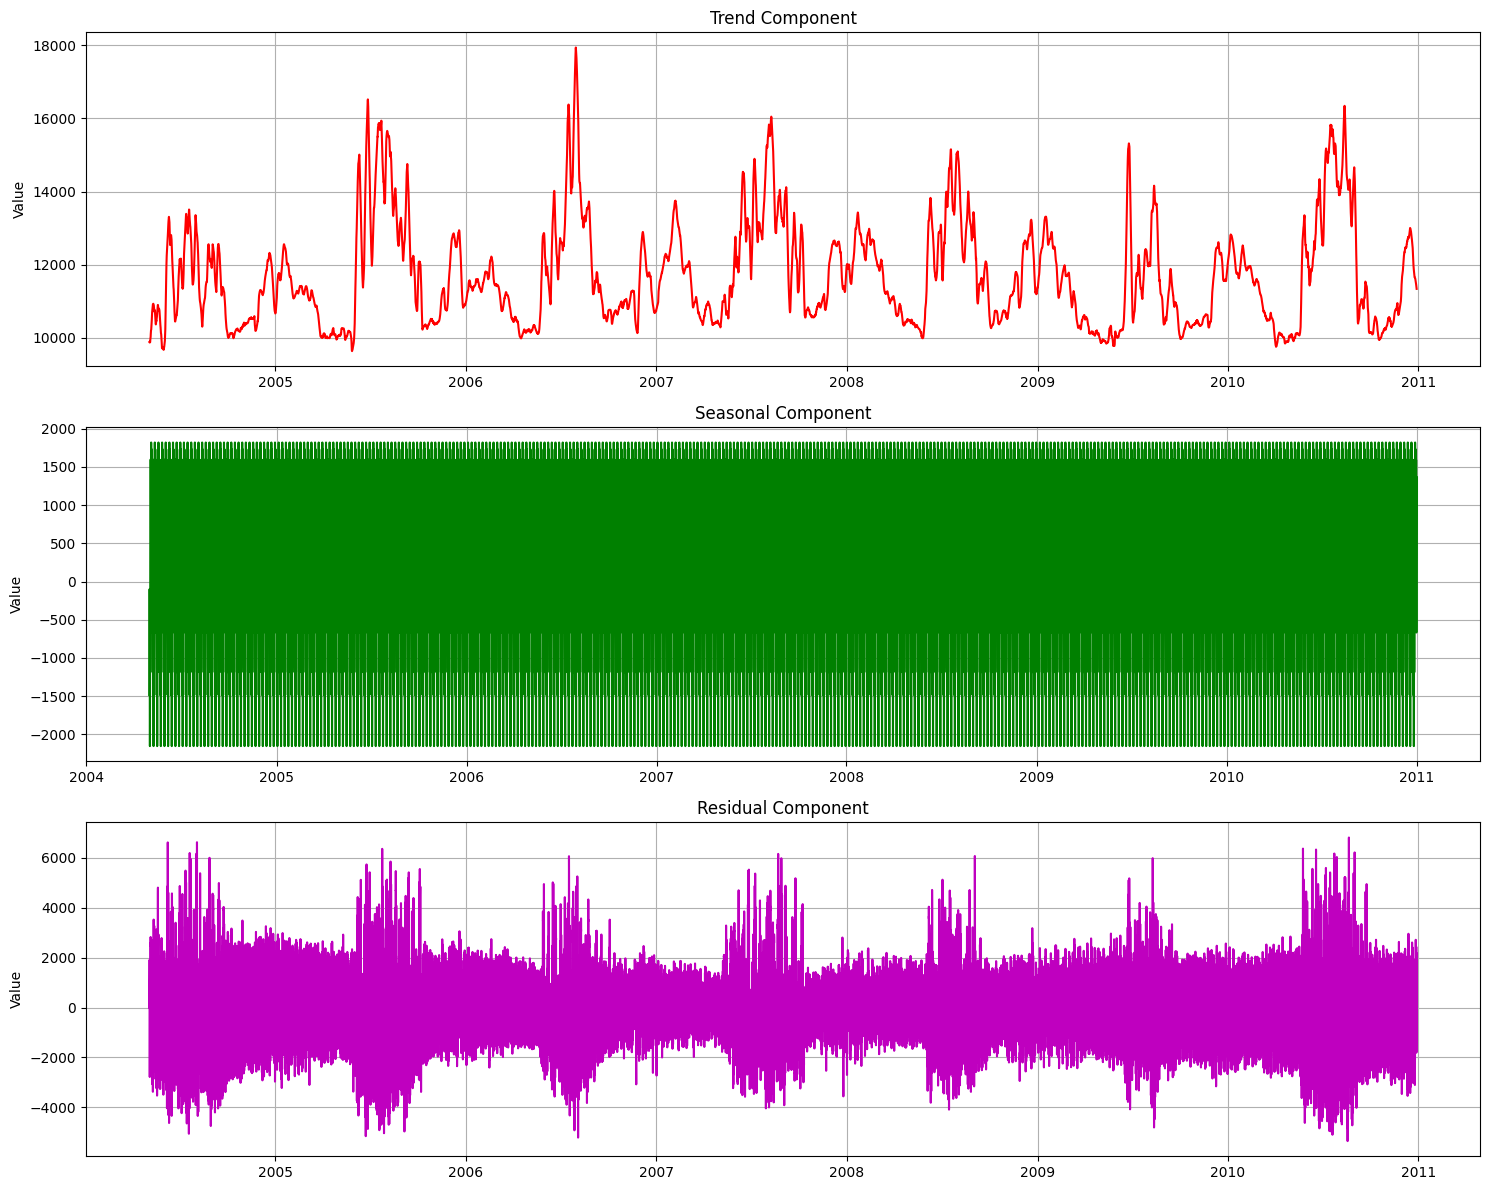

In [11]:
# Weekly decomposition

# Weekly seasonality 168 hours
weekly_decomposition = seasonal_decompose(
    ts_data, model="additive", period=24*7, extrapolate_trend=0
)
fig, (ax5, ax6, ax7) = plot.subplots(3, 1, figsize=(15, 12))

ax5.plot(weekly_decomposition.trend, 'r')
ax5.set_title('Trend Component')
ax5.set_ylabel('Value')
ax5.grid()

# THis plot needs to be cleaned up
ax6.plot(weekly_decomposition.seasonal, 'g')
ax6.set_title('Seasonal Component')
ax6.set_ylabel('Value')
ax6.grid()

ax7.plot(weekly_decomposition.resid, 'm')
ax7.set_title('Residual Component')
ax7.set_ylabel('Value')
ax7.grid()

plot.tight_layout()
plot.show()

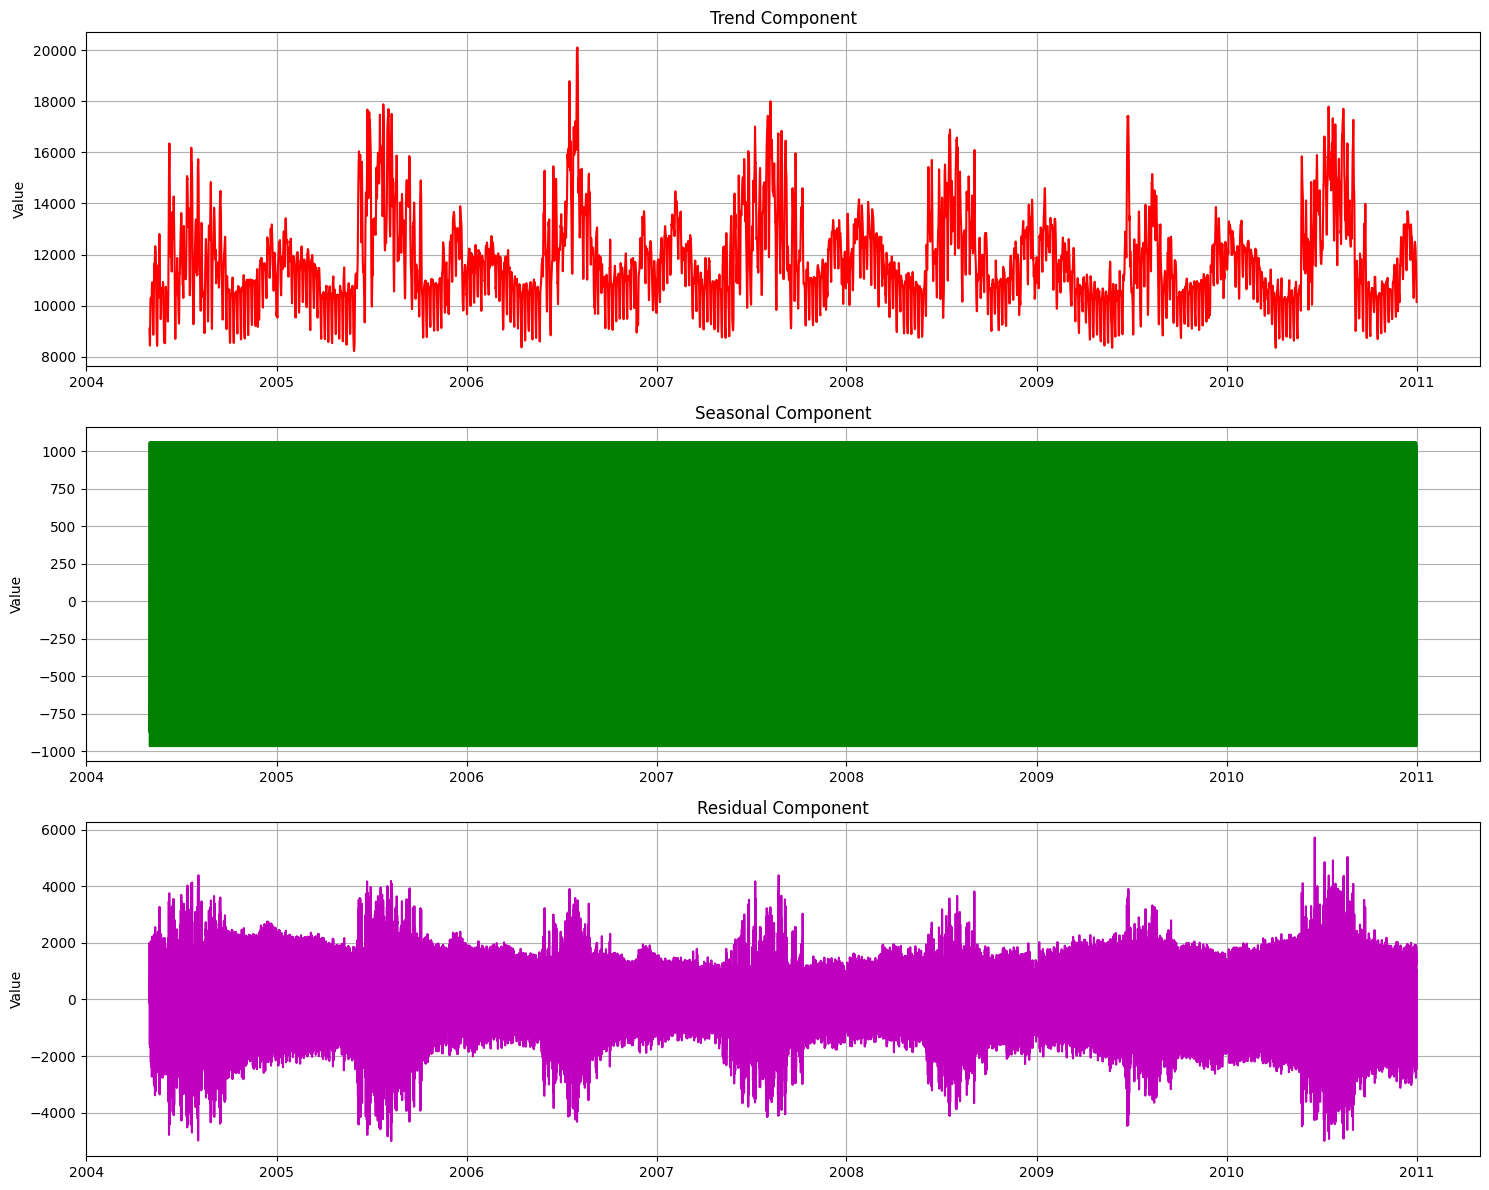

In [12]:
# Daily decomposition
# Daily seasonality 24 hours
daily_decomposition = seasonal_decompose(
    ts_data, model="additive", period=24, extrapolate_trend=0
)

fig, (ax8, ax9, ax10) = plot.subplots(3, 1, figsize=(15, 12))

ax8.plot(daily_decomposition.trend, 'r')
ax8.set_title('Trend Component')
ax8.set_ylabel('Value')
ax8.grid()
# THis plot needs to be cleaned up
ax9.plot(daily_decomposition.seasonal, 'g')
ax9.set_title('Seasonal Component')
ax9.set_ylabel('Value')
ax9.grid()

ax10.plot(daily_decomposition.resid, 'm')
ax10.set_title('Residual Component')
ax10.set_ylabel('Value')
ax10.grid()

plot.tight_layout()
plot.show()

<Figure size 1500x1200 with 0 Axes>

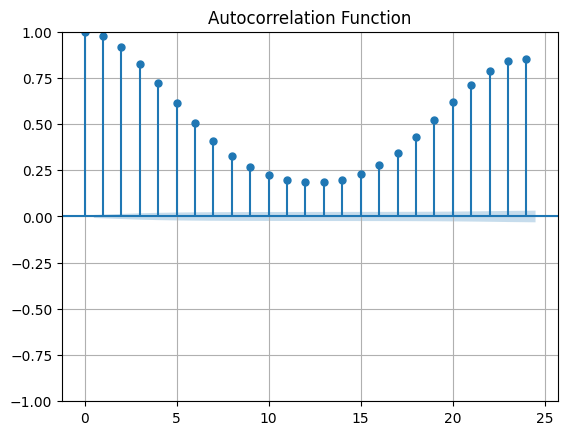

In [13]:
# Plot autocorrelation
plot.figure(figsize=(15, 12))
plot_acf(energy_data['NI_MW'], lags=24)
plot.grid(True)
plot.title('Autocorrelation Function')
plot.show()

In [14]:
# data statistics

print("Analyzing time steps...")

# Sort by datetime and calculate time differences
energy_data = energy_data.sort_values('Datetime')
time_diffs = energy_data['Datetime'].diff()

# Get unique time differences
unique_diffs = time_diffs.unique()
unique_diffs = unique_diffs[~pd.isnull(unique_diffs)]

print("Unique time differences found:")
for diff in unique_diffs:
    count = len(time_diffs[time_diffs == diff])
    print(f"- {diff}: {count} occurrences")

# Analyze missing values
print("\nMissing values per column:")
missing_values = energy_data.isnull().sum()


for col in energy_data.columns:
    print(f"{col}: {missing_values[col]}")


Analyzing time steps...
Unique time differences found:
- 0 days 01:00:00: 58435 occurrences
- 0 days 02:00:00: 14 occurrences

Missing values per column:
Datetime: 0
NI_MW: 0
hour: 0
date: 0


In [15]:
print("Analyzing time steps...")

# Sort by datetime and calculate time differences
energy_data = energy_data.sort_values('Datetime')
time_diffs = energy_data['Datetime'].diff()

# Get unique time differences
unique_diffs = time_diffs.unique()
unique_diffs = unique_diffs[~pd.isnull(unique_diffs)]

print("Unique time differences found:")
for diff in unique_diffs:
    count = len(time_diffs[time_diffs == diff])
    print(f"- {diff}: {count} occurrences")

# Find rows where time diff is 2 hours 
two_hour_mask = time_diffs == pd.Timedelta(hours=2)

print("\nTwo hour time steps found:")
for prev, curr in zip(energy_data['Datetime'].shift()[two_hour_mask], 
                     energy_data['Datetime'][two_hour_mask]):
    print(f"Gap between {prev} and {curr}")

# Analyze missing values
print("\nMissing values per column:")
missing_values = energy_data.isnull().sum()

for col in energy_data.columns:
    print(f"{col}: {missing_values[col]}")

Analyzing time steps...
Unique time differences found:
- 0 days 01:00:00: 58435 occurrences
- 0 days 02:00:00: 14 occurrences

Two hour time steps found:
Gap between 2004-10-31 01:00:00 and 2004-10-31 03:00:00
Gap between 2005-04-03 02:00:00 and 2005-04-03 04:00:00
Gap between 2005-10-30 01:00:00 and 2005-10-30 03:00:00
Gap between 2006-04-02 02:00:00 and 2006-04-02 04:00:00
Gap between 2006-10-29 01:00:00 and 2006-10-29 03:00:00
Gap between 2007-03-11 02:00:00 and 2007-03-11 04:00:00
Gap between 2007-11-04 01:00:00 and 2007-11-04 03:00:00
Gap between 2008-03-09 02:00:00 and 2008-03-09 04:00:00
Gap between 2008-11-02 01:00:00 and 2008-11-02 03:00:00
Gap between 2009-03-08 02:00:00 and 2009-03-08 04:00:00
Gap between 2009-11-01 01:00:00 and 2009-11-01 03:00:00
Gap between 2010-03-14 02:00:00 and 2010-03-14 04:00:00
Gap between 2010-11-07 01:00:00 and 2010-11-07 03:00:00
Gap between 2010-12-09 23:00:00 and 2010-12-10 01:00:00

Missing values per column:
Datetime: 0
NI_MW: 0
hour: 0
date:

In [16]:
# Index swapping 
energy_data.index = energy_data['Datetime']
print(energy_data.index)

DatetimeIndex(['2004-05-01 01:00:00', '2004-05-01 02:00:00',
               '2004-05-01 03:00:00', '2004-05-01 04:00:00',
               '2004-05-01 05:00:00', '2004-05-01 06:00:00',
               '2004-05-01 07:00:00', '2004-05-01 08:00:00',
               '2004-05-01 09:00:00', '2004-05-01 10:00:00',
               ...
               '2010-12-31 15:00:00', '2010-12-31 16:00:00',
               '2010-12-31 17:00:00', '2010-12-31 18:00:00',
               '2010-12-31 19:00:00', '2010-12-31 20:00:00',
               '2010-12-31 21:00:00', '2010-12-31 22:00:00',
               '2010-12-31 23:00:00', '2011-01-01 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=58450, freq=None)


## Hyperparameters below

In [17]:
## Hyperparamters dict
# Prepare sliding window dataset (X, Y)
hyperparameters  = {
    # How much data is considered for predictions / current param looks at a week
    'window_size' : 24 * 7,
    # Forecasting one hour ahead
    'forecast_horizon' : 1,
    # Number of timesteps moved forward each iteration
    # Larger stride means less predictions smaller stride, means more predictions
    'stride' : 168,
    # Hyperparams
    'rnn_epochs' : 1,
    'lstm_epochs' : 1,
    'autoreg_epochs' : 1,
    'lstm_network_size' : 256,
    'rnn_network_size' : 256,
    'batch_size' : 64,
    
}
# Validate dict
print(hyperparameters.get('window_size'))
# Helpers -- J

168


## Scaling the decomposed data into variables for the model
- Note: Using the yearly seasonal decomposition to train the final prodcut on how seasons change on a yearly basis - yearly decomposed values exhibit a strong yearly change in energy consumption habits.

- Using the daily trend and residual values, as we are predicting hourly consumption so those seem most relevant here

In [18]:
# Init scaler -- Use minmax scaler suggested by lit review
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_trend = MinMaxScaler(feature_range=(0, 1))
scaler_seasonal = MinMaxScaler(feature_range=(0, 1))

# Reshape decomp vals for Predictions
# Just a thought
residual = daily_decomposition.resid.dropna().values.reshape(-1, 1)
trend = daily_decomposition.trend.dropna().values.reshape(-1, 1)
seasonal = decomposition.seasonal.dropna().values.reshape(-1, 1)

# Scale decomp values for Predictions
residual_scaled = scaler.fit_transform(residual)
trend_scaled = scaler_trend.fit_transform(trend)
seasonal_scaled = scaler_seasonal.fit_transform(seasonal)

# Make sure X and Y values align - predictions done on resixs
X_residual = residual_scaled[:-hyperparameters.get('forecast_horizon')]  
Y_residual = residual_scaled[hyperparameters.get('forecast_horizon'):]

X_trend = trend_scaled[:-hyperparameters.get('forecast_horizon')]  
Y_trend = trend_scaled[hyperparameters.get('forecast_horizon'):]

X_seasonal = seasonal_scaled[:-hyperparameters.get('forecast_horizon')]  
Y_seasonal = seasonal_scaled[hyperparameters.get('forecast_horizon'):]


In [19]:
# Fix for gpu vs cpu usage- Don't run if no problems exist
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=0"


## Autoregression

- Created as a baseline model
- Features fed to model
- Trend and Seasonal components
- Lag for rolling window set to window size

In [20]:
from statsmodels.tsa.ar_model import AutoReg

T = hyperparameters.get('window_size')
X = []  # Features
Y = []  # Target variable (next residual)

# Loop through residuals - X = trend and seasonal components as features, Y is the next residual
for t in range(len(residual_scaled) - T):
    # Combine trend and seasonal components as features (do not include residuals in X)
    X.append(np.concatenate((
        trend_scaled[t:t + T],  
        seasonal_scaled[t:t + T]  
    ), axis=1))  
    
    Y.append(residual_scaled[t + T]) 

X = np.array(X) 
Y = np.array(Y)

# Step 3: Define the autoregressive model using a Dense neural network
# Number of lags/Window = Shape, with the feature amount as the second var
i = Input(shape=(T, 2))  
x = Dense(1)(i)  
model = Model(i, x)

# Compile 
model.compile(
    loss='mse',  
    optimizer='adam',
    metrics=['mse']
)

# Init empty lists
autoreg_predictions = []
autoreg_actual_values = []
autoreg_timestamps = []

# Rolling window for predictions
for start in range(0, len(X) - T, hyperparameters.get('stride')):
    # Define the end of the window for training
    end = start + hyperparameters.get('window_size')  # Actual window's end index
    
    X_train = X[start:end]  
    Y_train = Y[start:end]  
    
    # Train the model using the iterated data
    model.fit(X_train, Y_train, epochs=hyperparameters.get('autoreg_epochs'), batch_size=hyperparameters.get('batch_size'))
    
    # Predict a value
    predicted_residual = model.predict(X[end:end+1])  # Predict for the next step (after the window)
    autoreg_predictions.append(predicted_residual.flatten()[0])  # Store the predicted residual
    
    # Actual residual to storage
    autoreg_actual_values.append(Y[end])  
    
    # Store timestamp
    autoreg_timestamps.append(energy_data['Datetime'][end])  # Timestamp corresponding to the prediction

# Done with predictions and timestamps
print('Done')



3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4237 - mse: 0.4237
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4128 - mse: 0.4128


C:\Users\erikb\AppData\Local\Temp\ipykernel_9372\1376940518.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  autoreg_timestamps.append(energy_data['Datetime'][end])  # Timestamp corresponding to the prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4445 - mse: 0.4445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4844 - mse: 0.4844
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6085 - mse: 0.6085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7515 - mse: 0.7515
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7149 - mse: 0.7149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8424 - mse: 0.8424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6566 - mse: 0.6566 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8198 - mse: 0.8198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9619 - mse: 0.9619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3/3 ━━━━━━━━━━━━━

In [21]:
def reseasonalize_values(predictions, seasonals, trends, timestamps):
    
    original_consumption_data = energy_data['NI_MW'].values
    original_consumption_data = original_consumption_data[:len(timestamps)]
        
    # Reseasonalize predictions
        
    #seasonal_values = seasonal[len(seasonal) - len(predictions):].flatten()
    #trend_values = trend[len(trend) - len(predictions):].flatten()
    
    reseasonalized_predictions = predictions + seasonals + trends
    
    return original_consumption_data, reseasonalized_predictions
    
def plot_out_predictions(all_predictions, all_true_values, timestamps, reseasonalized_predictions, original_consumption, model, pred_color):
    
    fig, (pr1, pr2) = plot.subplots(2, 1, figsize=(15, 12))
    # First subplot
    pr1.plot(timestamps, all_true_values, 'orange', linewidth=2, label='True values')
    pr1.plot(timestamps, all_predictions, color=pred_color, linewidth=2, label = 'Predicted values')
    pr1.set_title(f'True vs Predicted Residuals using: {model}')
    pr1.set_xlabel('Time')
    pr1.legend()
    pr1.set_ylabel('Residual')
    pr1.grid(True)

    # Second subplot
    pr2.plot(timestamps, original_consumption, linewidth=2, color='orange', label='True values')
    pr2.plot(timestamps, reseasonalized_predictions, linewidth=2, color=pred_color, label = 'Predicted values')  
    pr2.set_title(f'True vs Predicted Energy consumption using: {model}')
    pr2.set_xlabel('Time')
    pr2.legend()
    pr2.set_ylabel('Energy consumption in MwH')
    pr2.grid(True)
    plot.tight_layout()
    plot.show()

In [22]:
# Rescale values
def rescale_values(given_predictions, given_true_values):
    # Rescale residuals
    rescaled_predictions = scaler.inverse_transform(np.array(given_predictions).reshape(-1, 1)).flatten()
    rescaled_originals = scaler.inverse_transform(np.array(given_true_values).reshape(-1, 1)).flatten()
    return rescaled_predictions, rescaled_originals

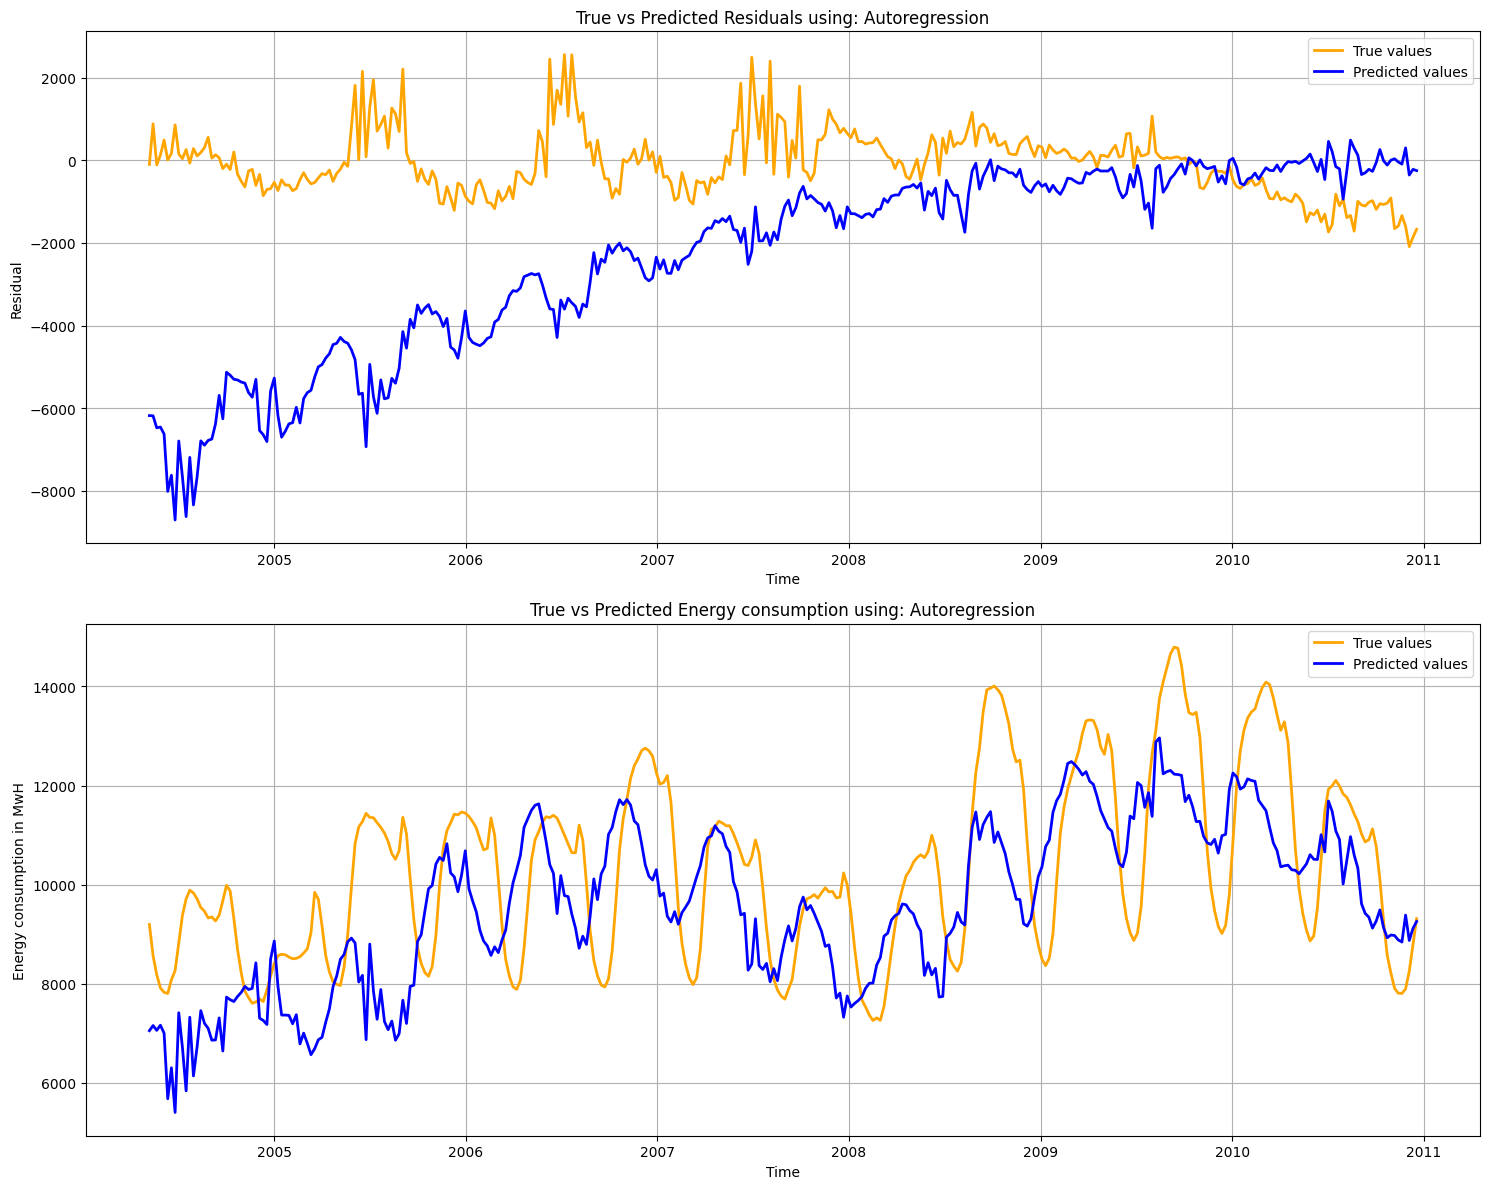

In [23]:

# Rescale, reseason and plot

# Rescale
predicted_residuals_unscaled, actual_residuals_unscaled = rescale_values(autoreg_predictions, autoreg_actual_values)


# Create seasonalization vars
autoreg_seasonal_values = seasonal[len(seasonal) - len(predicted_residuals_unscaled):].flatten()
autoreg_trend_values = trend[len(trend) - len(predicted_residuals_unscaled):].flatten()

# Reseasonalize
original_consumption_data, a_reg_reseasonalized_predictions = reseasonalize_values(predicted_residuals_unscaled, autoreg_seasonal_values,autoreg_trend_values, autoreg_timestamps)


plot_out_predictions(
    all_predictions=predicted_residuals_unscaled,
    all_true_values=actual_residuals_unscaled,
    timestamps=autoreg_timestamps,
    reseasonalized_predictions=a_reg_reseasonalized_predictions,
    original_consumption=original_consumption_data,
    model='Autoregression',
    pred_color='blue'

)


In [24]:
def run_model_2(model, batch_size, epochs, window_size, forecast_horizon, stride):
    all_predictions = []
    all_true_values = []
    
    timestamps = []

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'root_mean_squared_error'])

    for start in range(0, len(residual) - window_size - forecast_horizon, stride):
        train_start = start
        train_end = start + window_size
        val_start = train_end
        val_end = val_start + forecast_horizon
    
        # Feed all values as separate features to the model
        X_train_combined = np.concatenate((
           # X_residual[train_start:train_end], 
            X_trend[train_start:train_end], 
            X_seasonal[train_start:train_end]
        ), axis=1)  # Combine along the feature lstm_timestampsnsion

        X_train_combined = X_train_combined.reshape(-1, 1, X_train_combined.shape[1])  # (samples, timesteps=1, features)

        
        Y_train = Y_residual[train_start:train_end]  # The target is still the residual for autoregression

        # Validation set
        X_val_combined = np.concatenate((
        #    X_residual[val_start:val_end], 
            X_trend[val_start:val_end], 
            X_seasonal[val_start:val_end]
        ), axis=1)

        X_val_combined = X_val_combined.reshape(-1, 1, X_val_combined.shape[1])  # (samples, timesteps=1, features)
        
        Y_val = Y_residual[val_start:val_end]

        # Train the combined model
        model.fit(X_train_combined, Y_train, validation_data=(X_val_combined, Y_val), epochs=epochs, batch_size=batch_size)
    
        # Evaluate the model on validation set
        predictions = model.predict(X_val_combined, batch_size=batch_size)
        print(predictions)

        # Store the predictions and true values
        all_predictions.extend(predictions.flatten())
        all_true_values.extend(Y_val.flatten())
    
        # Store the corresponding timestamps for plotting
        timestamps.extend(energy_data['Datetime'][val_start:val_end].values)

    print('Finished')
    return all_predictions, all_true_values, timestamps

## LSTM Model

In [25]:
lstm = Sequential([
    LSTM(hyperparameters.get('lstm_network_size')),
    # Linear activation for regression tasks
    Dense(1, activation='linear') #
])
lstm_predictions, lstm_true_values, lstm_timestamps = run_model_2(
    model = lstm,
    batch_size = hyperparameters.get('batch_size'), 
    epochs = hyperparameters.get('lstm_epochs'),
    window_size = hyperparameters.get('window_size'),
    forecast_horizon = hyperparameters.get('forecast_horizon'),
    stride = hyperparameters.get('stride'),
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - loss: 0.2337 - mae: 0.4671 - root_mean_squared_error: 0.4832 - val_loss: 0.1991 - val_mae: 0.4462 - val_root_mean_squared_error: 0.4462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
[[0.02123765]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2179 - mae: 0.4383 - root_mean_squared_error: 0.4668 - val_loss: 0.1790 - val_mae: 0.4230 - val_root_mean_squared_error: 0.4230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[[0.04189107]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1836 - mae: 0.4023 - root_mean_squared_error: 0.4285 - val_loss: 0.2420 - val_mae: 0.4919 - val_root_mean_squared_error: 0.4919
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.07322868]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1665 - mae: 0.3828 - root_mean_squared_error: 0.4080 - val_loss: 0.1438 - val_mae: 0.3792 - val_root_mean_squared_error: 0.3792
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.08799491]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1476 - mae: 0.3627 - root_mean_sq

## LSTM plots, rescaling and reseasonalization

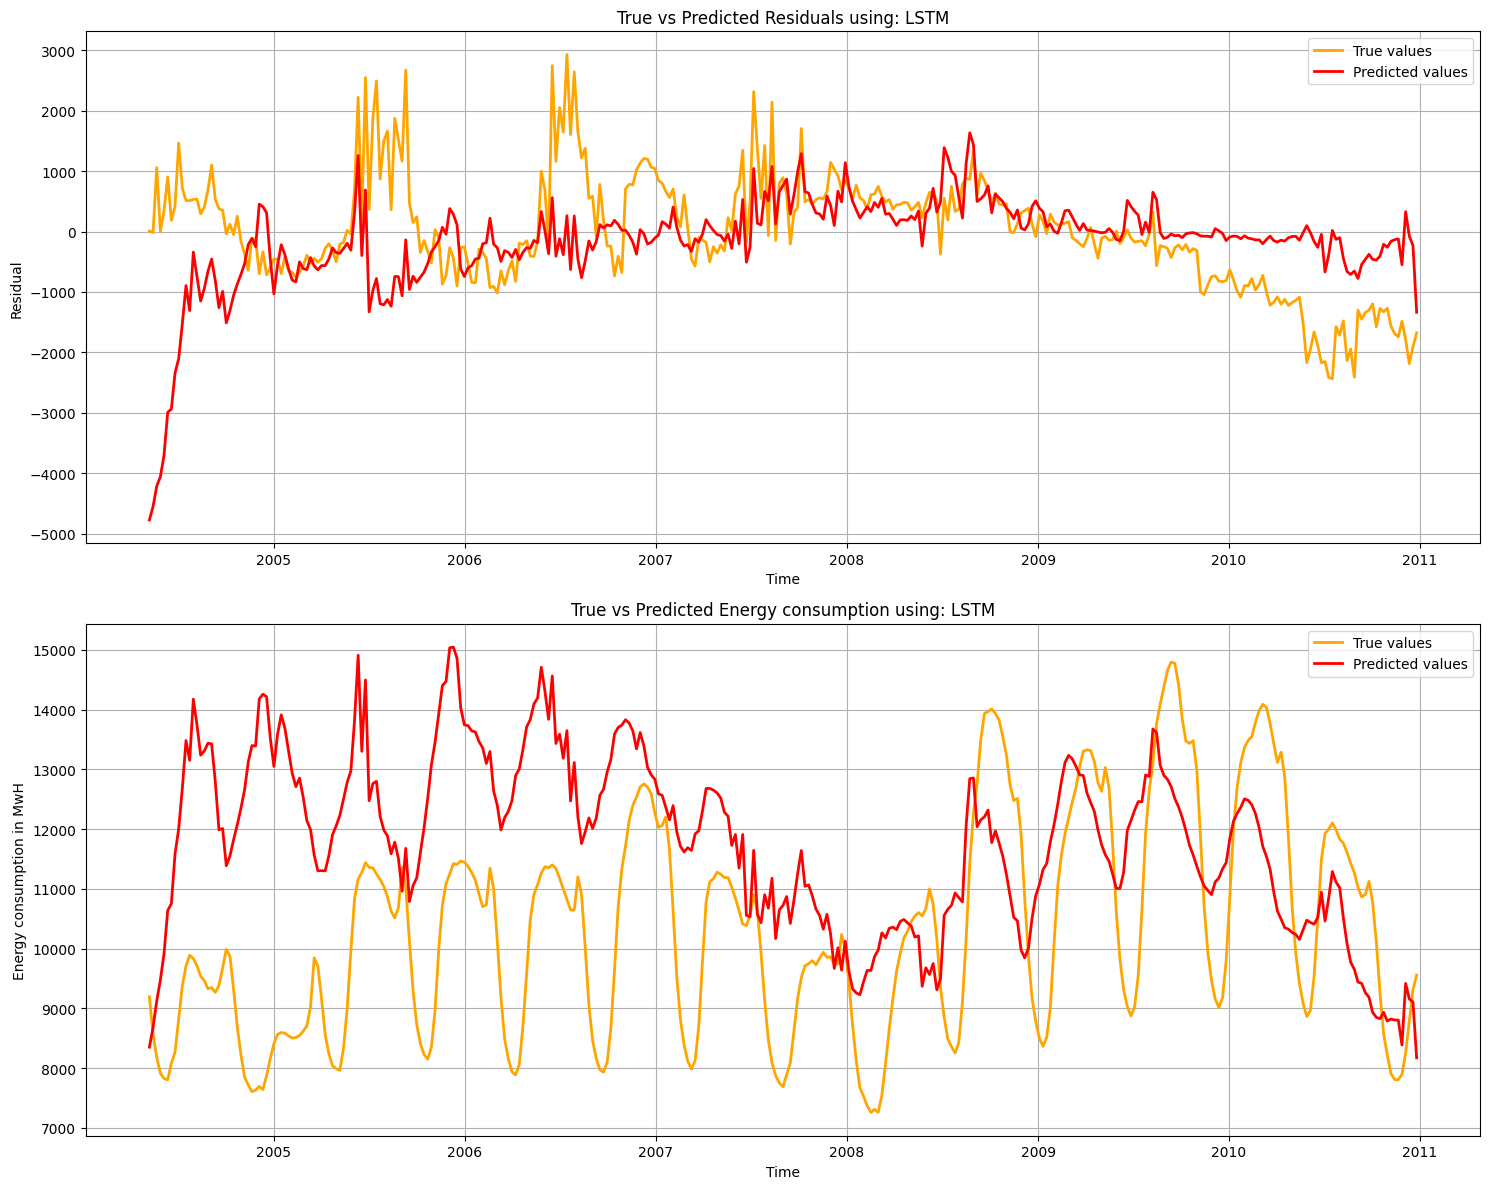

In [26]:
# Reseasonalize, rescale and plot out
seasonal_values = seasonal[len(seasonal) - len(lstm_predictions):].flatten()
trend_values = trend[len(trend) - len(lstm_predictions):].flatten()

# Rescale
lstm_predictions_scaled, lstm_trues_scaled = rescale_values(lstm_predictions, lstm_true_values)
# Reseasonalize
original_consumption, lstm_reseasonalized_predictions = reseasonalize_values(lstm_predictions_scaled, seasonal_values, trend_values, lstm_timestamps)

# Plot
plot_out_predictions(lstm_predictions_scaled,lstm_trues_scaled,lstm_timestamps, lstm_reseasonalized_predictions, original_consumption, 'LSTM','red')



## RNN Model

In [27]:
# Variable storage
# Prepare model once before the loop
rnn_model = Sequential([
    SimpleRNN(hyperparameters.get('rnn_network_size')),
    # Linear or no activation for regression tasks
    Dense(1, activation='linear')
])

# Run model

rnn_predictions, rnn_all_true_values, rnn_timestamps = run_model_2(
    model = rnn_model,
    batch_size = hyperparameters.get('batch_size'), 
    epochs = hyperparameters.get('rnn_epochs'),
    window_size = hyperparameters.get('window_size'),
    forecast_horizon = hyperparameters.get('forecast_horizon'),
    stride = hyperparameters.get('stride'),
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - loss: 0.2402 - mae: 0.4738 - root_mean_squared_error: 0.4901 - val_loss: 0.1623 - val_mae: 0.4028 - val_root_mean_squared_error: 0.4028
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
[[0.06456546]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1805 - mae: 0.3942 - root_mean_squared_error: 0.4246 - val_loss: 0.1025 - val_mae: 0.3202 - val_root_mean_squared_error: 0.3202
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0.14470743]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1059 - mae: 0.2911 - root_mean_squared_error: 0.3253 - val_loss: 0.1051 - val_mae: 0.3241 - val_root_mean_squared_error: 0.3241
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[0.24106212]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0527 - mae: 0.1987 - root_mean_squared_error: 0.2295 - val_loss: 0.0265 - val_mae: 0.1627 - val_root_mean_squared_error: 0.1627
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[0.3044445]]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0237 - mae: 0.1361 - root_mean_squa

## RNN Plots etc..

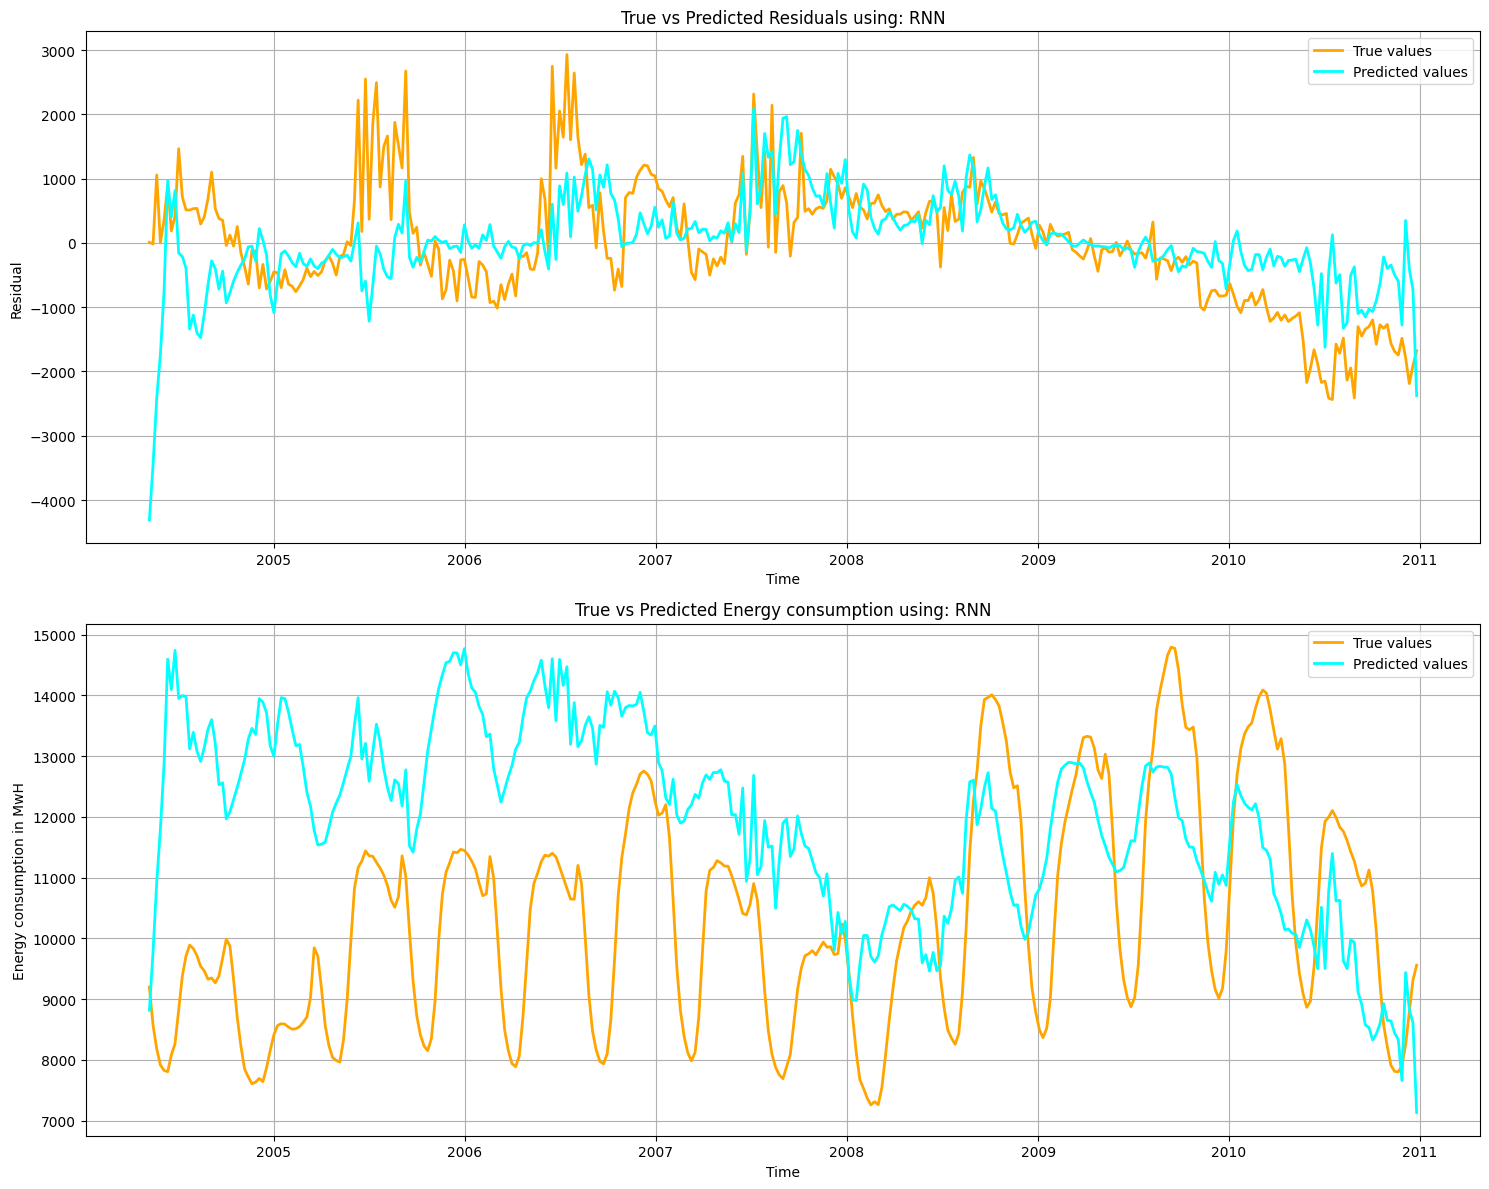

In [28]:
# Rescale
rnn_predictions_rescaled, rnn_orignals_rescaled = rescale_values(rnn_predictions, rnn_all_true_values)
# Reseasonalize
seasonal_values = seasonal[len(seasonal) - len(rnn_predictions):].flatten()
trend_values = trend[len(trend) - len(rnn_predictions):].flatten()

original_consumption, reseasonalized_rnn_predictions = reseasonalize_values(rnn_predictions_rescaled, seasonal_values, trend_values ,rnn_timestamps)

# Plot out

plot_out_predictions(
                    rnn_predictions_rescaled, 
                     rnn_orignals_rescaled,
                     rnn_timestamps, 
                    reseasonalized_rnn_predictions, 
                    original_consumption,
                    'RNN',
                    'cyan'
)


## All models side by side compared against original values

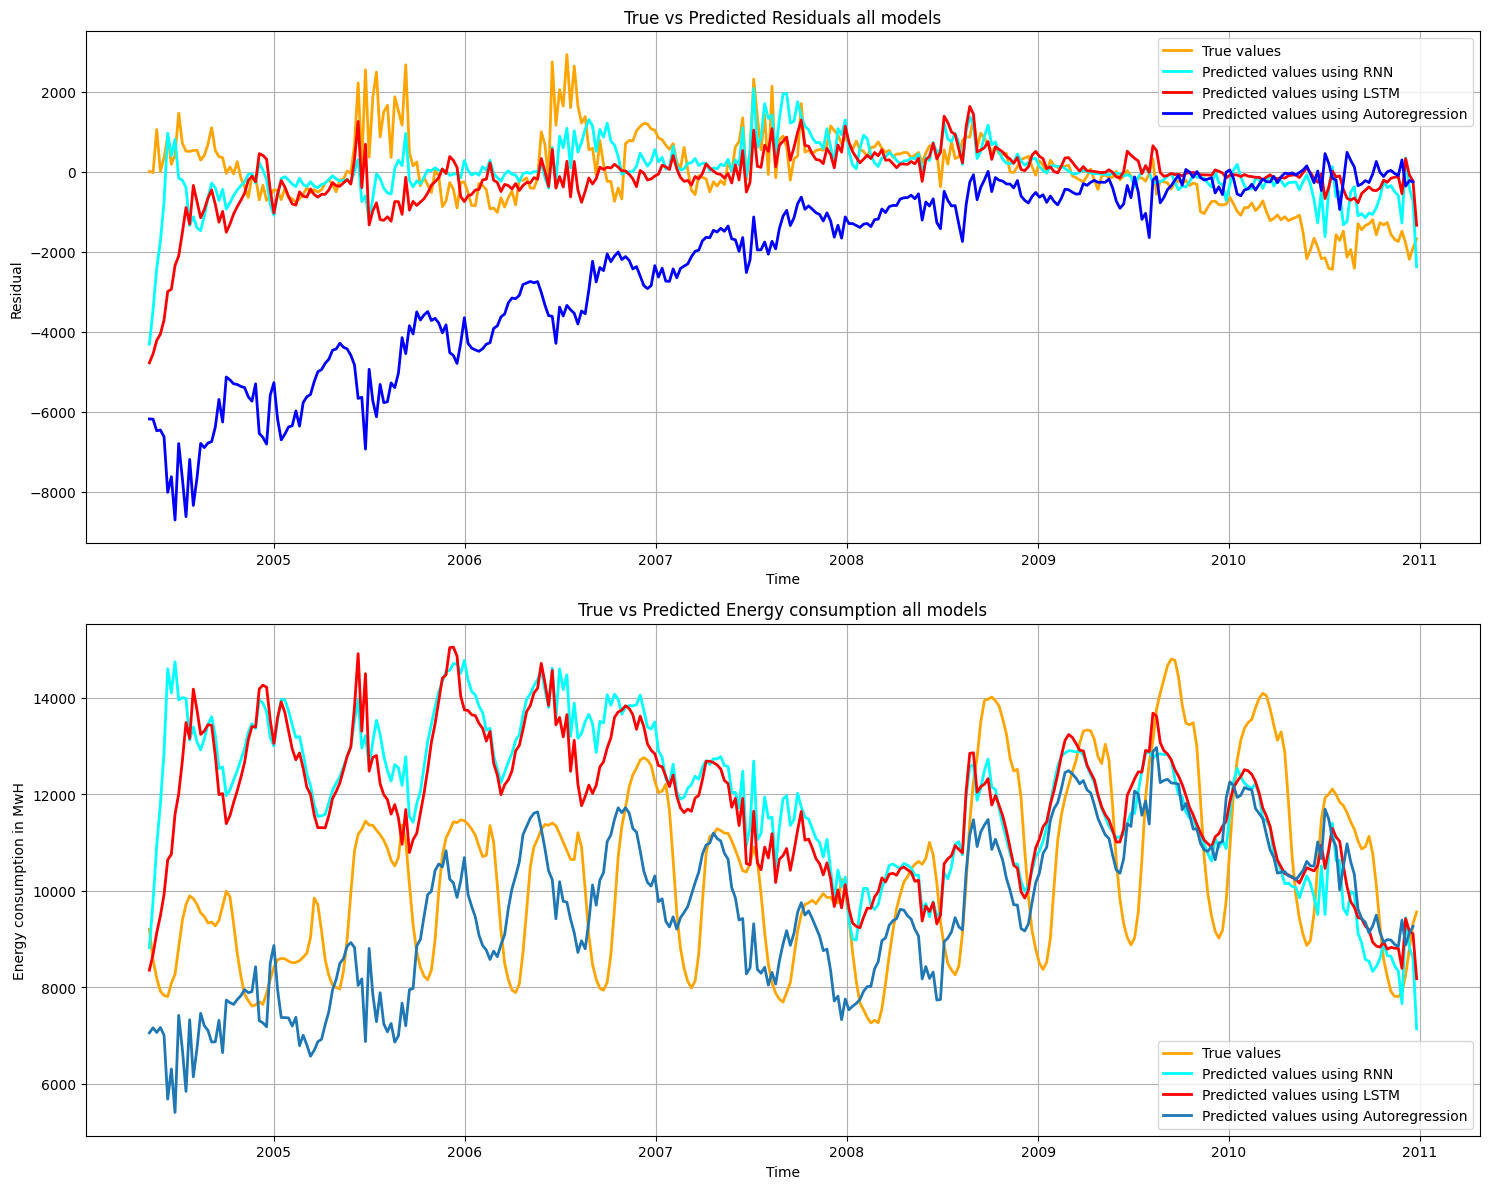

In [29]:

# All models side by side

# Plot out simultaneous
fig, (full1, full2) = plot.subplots(2, 1, figsize=(15, 12))
# Plot 1 
full1.set_title(f'True vs Predicted Residuals all models')
full1.plot(rnn_timestamps, rnn_orignals_rescaled, 'orange',  linewidth=2, label='True values')
full1.plot(rnn_timestamps, rnn_predictions_rescaled, 'cyan', linewidth=2, label = 'Predicted values using RNN')
full1.plot(lstm_timestamps, lstm_predictions_scaled, 'red', linewidth=2, label = 'Predicted values using LSTM')
full1.plot(autoreg_timestamps, predicted_residuals_unscaled, 'blue', linewidth=2, label = 'Predicted values using Autoregression')
full1.set_xlabel('Time')
full1.legend()
full1.set_ylabel('Residual')
full1.grid(True)
# Plot 2
full2.set_title(f'True vs Predicted Energy consumption all models')
full2.plot(rnn_timestamps, original_consumption, linewidth=2, color='orange', label='True values')
full2.plot(rnn_timestamps, reseasonalized_rnn_predictions,  linewidth=2, color='cyan', label = 'Predicted values using RNN')  
full2.plot(rnn_timestamps, lstm_reseasonalized_predictions,  linewidth=2, color='red', label = 'Predicted values using LSTM')
full2.plot(autoreg_timestamps, a_reg_reseasonalized_predictions, linewidth=2, label = 'Predicted values using Autoregression')
full2.set_xlabel('Time')
full2.legend()
full2.set_ylabel('Energy consumption in MwH')
full2.grid(True)
plot.tight_layout()
plot.show()
    

## Transformer Model

The iTransformer architecture is used for our Transformer Model

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class iTransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=8, num_layers=3, dropout=0.1):
        super().__init__()
        
        self.input_projection = nn.Linear(input_dim, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        self.output_projection = nn.Linear(d_model, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features)
        x = self.input_projection(x)
        x = self.transformer_encoder(x)
        # Take the last sequence element for prediction
        x = x[:, -1, :]
        x = self.output_projection(x)
        return x

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



In [31]:
def run_itransformer(X_trend, X_seasonal, Y_residual, hyperparameters, device='cpu'):
    all_predictions = []
    all_true_values = []
    timestamps = []
    
    window_size = hyperparameters.get('window_size')
    forecast_horizon = hyperparameters.get('forecast_horizon')
    stride = hyperparameters.get('stride')
    batch_size = hyperparameters.get('batch_size')
    epochs = hyperparameters.get('transformer_epochs', 1)  # Default to 1 if not specified
    
    # Initialize model
    input_dim = 2  # trend and seasonal features
    model = iTransformerModel(input_dim=input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    for start in range(0, len(Y_residual) - window_size - forecast_horizon, stride):
        train_start = start
        train_end = start + window_size
        val_start = train_end
        val_end = val_start + forecast_horizon
        
        # Combine features
        X_train_combined = np.stack((
            X_trend[train_start:train_end].flatten(),
            X_seasonal[train_start:train_end].flatten()
        ), axis=1)
        
        X_val_combined = np.stack((
            X_trend[val_start:val_end].flatten(),
            X_seasonal[val_start:val_end].flatten()
        ), axis=1)
        
        Y_train = Y_residual[train_start:train_end]
        Y_val = Y_residual[val_start:val_end]
        
        # Create datasets and dataloaders
        train_dataset = TimeSeriesDataset(X_train_combined, Y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Training loop
        model.train()
        for epoch in range(epochs):
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_X.unsqueeze(1))  # Add sequence dimension
                loss = criterion(outputs.squeeze(), batch_y)
                loss.backward()
                optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            X_val_tensor = torch.FloatTensor(X_val_combined).to(device)
            predictions = model(X_val_tensor.unsqueeze(1)).cpu().numpy()
        
        all_predictions.extend(predictions.flatten())
        all_true_values.extend(Y_val.flatten())
        timestamps.extend(energy_data['Datetime'][val_start:val_end].values)
    
    return np.array(all_predictions), np.array(all_true_values), timestamps

# Add transformer epochs to hyperparameters
hyperparameters['transformer_epochs'] = 3

In [32]:
# Run the model
device = torch.device('cpu')
transformer_predictions, transformer_true_values, transformer_timestamps = run_itransformer(
    X_trend=X_trend,
    X_seasonal=X_seasonal,
    Y_residual=Y_residual,
    hyperparameters=hyperparameters,
    device=device
)

# Rescale values
transformer_predictions_scaled, transformer_trues_scaled = rescale_values(
    transformer_predictions, 
    transformer_true_values
)

# Reseasonalize
seasonal_values = seasonal[len(seasonal) - len(transformer_predictions):].flatten()
trend_values = trend[len(trend) - len(transformer_predictions):].flatten()

original_consumption, transformer_reseasonalized_predictions = reseasonalize_values(
    transformer_predictions_scaled, 
    seasonal_values, 
    trend_values,
    transformer_timestamps
)

c:\Users\erikb\anaconda3\envs\tf_2\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\erikb\anaconda3\envs\tf_2\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


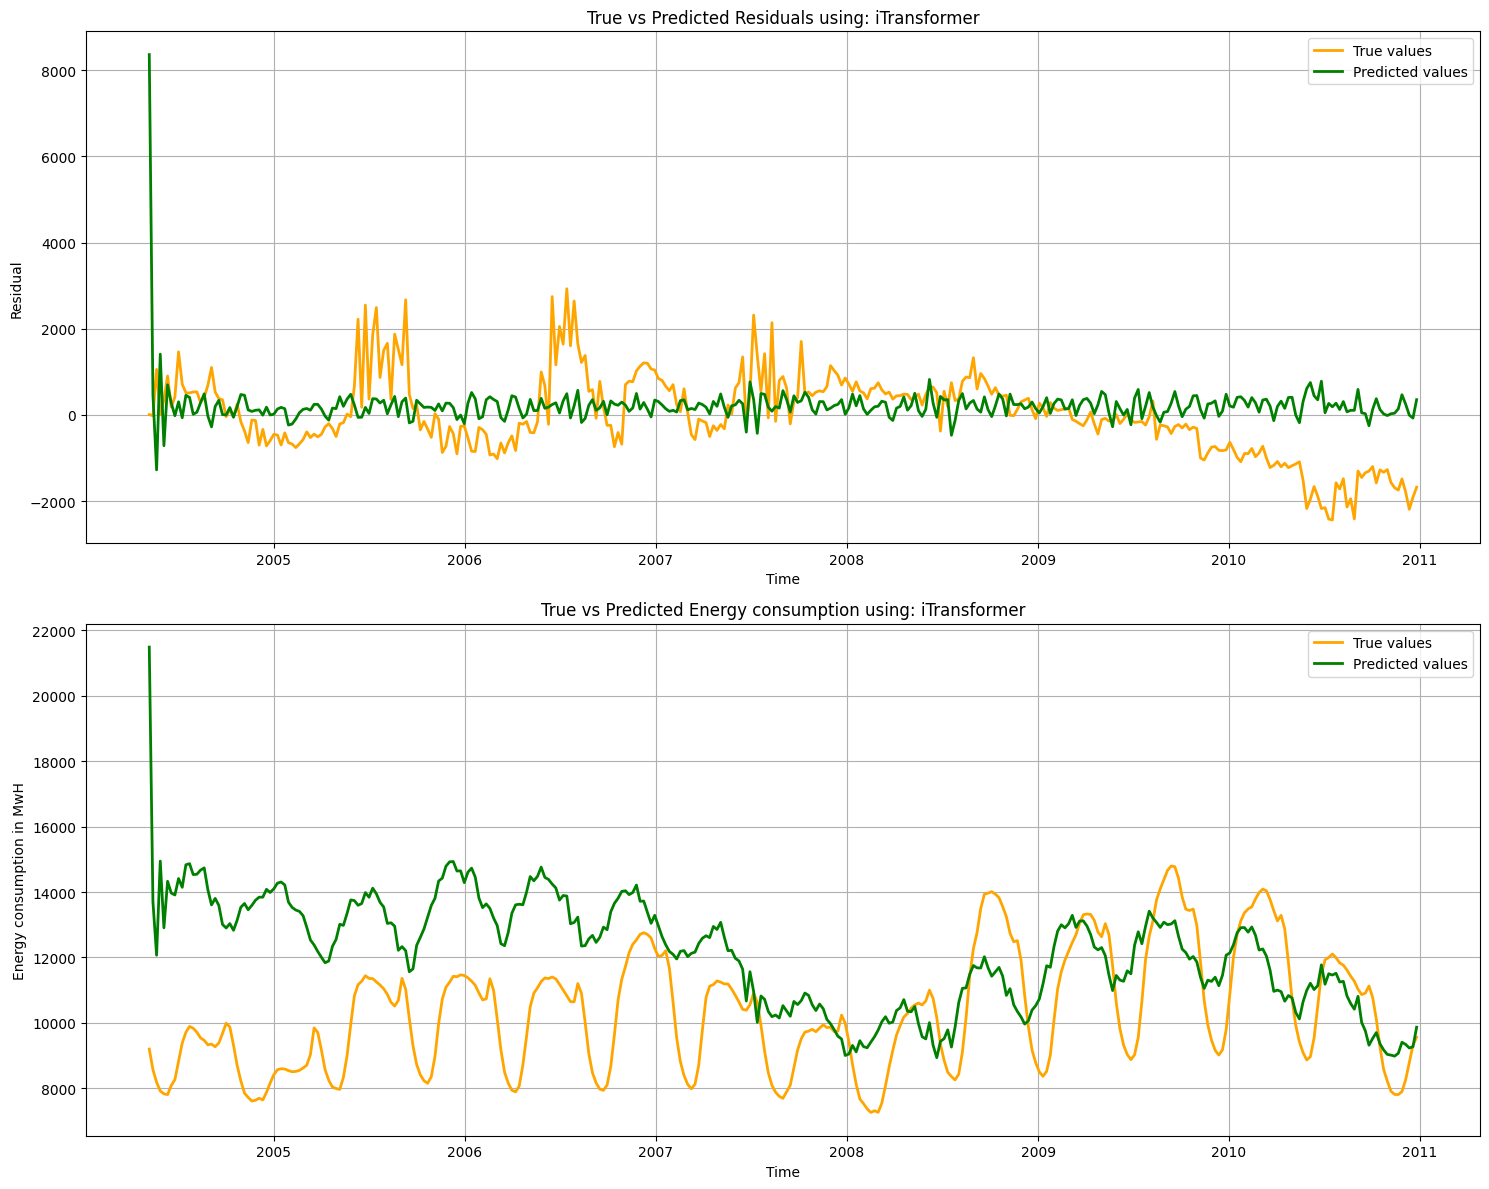

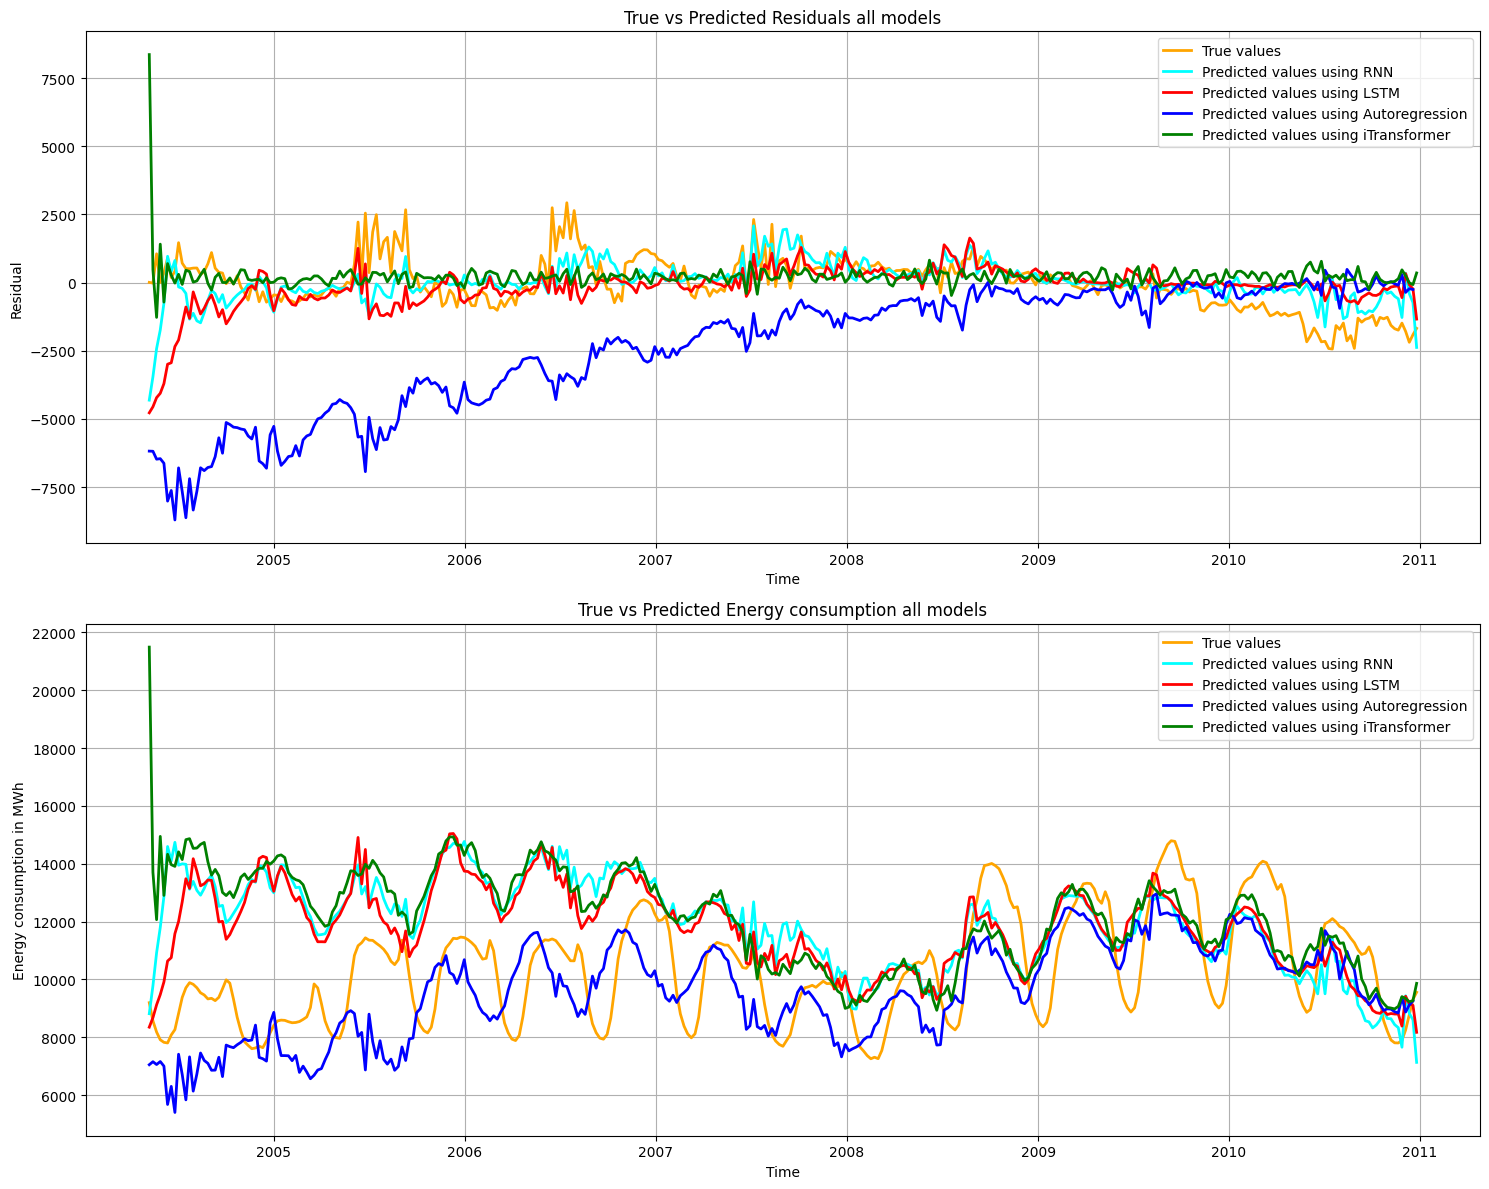

In [33]:
# Plot results
plot_out_predictions(
    transformer_predictions_scaled,
    transformer_trues_scaled,
    transformer_timestamps,
    transformer_reseasonalized_predictions,
    original_consumption,
    'iTransformer',
    'green'
)

# combined plot including transformer results
fig, (full1, full2) = plot.subplots(2, 1, figsize=(15, 12))

# Plot 1 - Residuals
full1.set_title('True vs Predicted Residuals all models')
full1.plot(rnn_timestamps, rnn_orignals_rescaled, 'orange', linewidth=2, label='True values')
full1.plot(rnn_timestamps, rnn_predictions_rescaled, 'cyan', linewidth=2, label='Predicted values using RNN')
full1.plot(lstm_timestamps, lstm_predictions_scaled, 'red', linewidth=2, label='Predicted values using LSTM')
full1.plot(autoreg_timestamps, predicted_residuals_unscaled, 'blue', linewidth=2, label='Predicted values using Autoregression')
full1.plot(transformer_timestamps, transformer_predictions_scaled, 'green', linewidth=2, label='Predicted values using iTransformer')
full1.set_xlabel('Time')
full1.legend()
full1.set_ylabel('Residual')
full1.grid(True)

# Plot 2 - Energy consumption
full2.set_title('True vs Predicted Energy consumption all models')
full2.plot(rnn_timestamps, original_consumption, linewidth=2, color='orange', label='True values')
full2.plot(rnn_timestamps, reseasonalized_rnn_predictions, linewidth=2, color='cyan', label='Predicted values using RNN')
full2.plot(rnn_timestamps, lstm_reseasonalized_predictions, linewidth=2, color='red', label='Predicted values using LSTM')
full2.plot(autoreg_timestamps, a_reg_reseasonalized_predictions, linewidth=2, color='blue', label='Predicted values using Autoregression')
full2.plot(transformer_timestamps, transformer_reseasonalized_predictions, linewidth=2, color='green', label='Predicted values using iTransformer')
full2.set_xlabel('Time')
full2.legend()
full2.set_ylabel('Energy consumption in MWh')
full2.grid(True)
plot.tight_layout()
plot.show()